# Embeddings de Posición (Position Embeddings)

El mecanismo de Atención es "invariante a la permutación". Si barajas las palabras, la atención calcula lo mismo. Para arreglar esto, sumamos un vector de posición a cada vector de palabra.

Primero, extraemos la matriz de posiciones aprendida (`wpe`) de GPT-2.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2Model LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)
Tamaño de matriz de posiciones: (1024, 768)


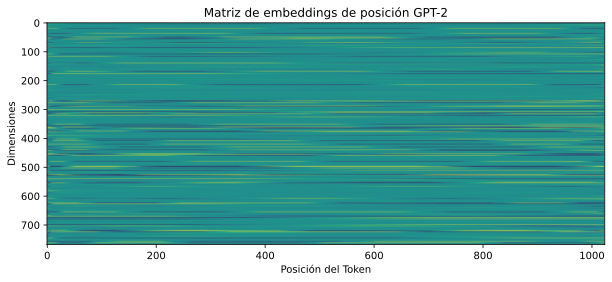

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# gráficos de alta resolución
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Cargar el modelo
from transformers import GPT2Model
gpt2 = GPT2Model.from_pretrained('gpt2')
print(gpt2)

# Obtener embeddings de posición (wpe = Word Position Embeddings)
positions = gpt2.wpe.weight.detach().numpy()

# Verificar el tamaño de esta matriz (Context Window x Embedding Dim)
print(f"Tamaño de matriz de posiciones: {positions.shape}")

# Visualizar la matriz
plt.figure(figsize=(10, 4))
plt.imshow(positions.T, aspect='auto', vmin=-.2, vmax=.2)
plt.gca().set(xlabel='Posición del Token', ylabel='Dimensiones', title='Matriz de embeddings de posición GPT-2')
plt.show()

## Visualizando Vectores de Posición (GPT-2)

Aquí vamos a graficar cómo cambia una **dimensión individual** a medida que avanzamos en el texto (del token 0 al 1024).

En teoría, deberíamos ver patrones que permitan al modelo distinguir "principio", "medio" y "final". Sin embargo, como son aprendidos (Learned), a menudo se ven ruidosos o "sucios".

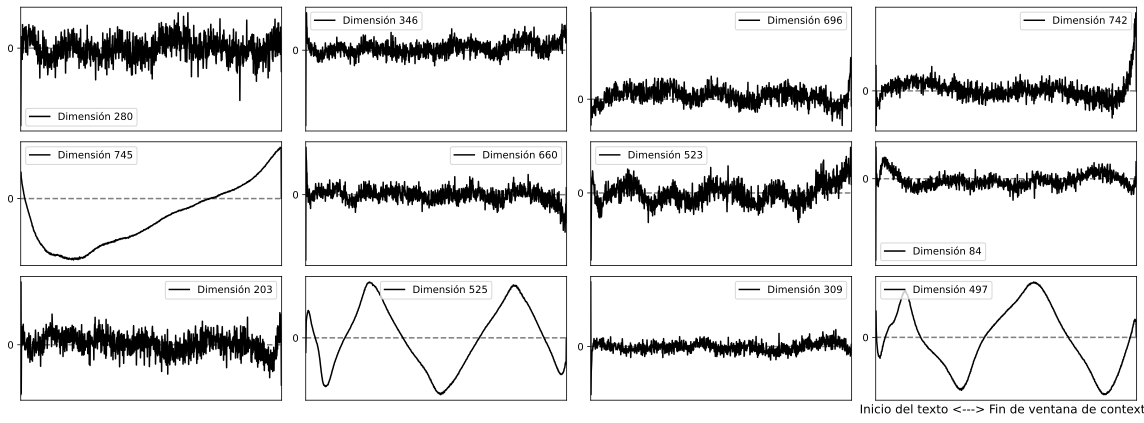

In [2]:
_, axs = plt.subplots(3, 4, figsize=(16, 6))

# Elegir vectores aleatorios (dimensiones específicas)
for a in axs.flatten():

  # Elegimos una dimensión aleatoria (columna) entre 0 y 768
  randidx = np.random.randint(positions.shape[1])

  # Y la graficamos a través de todas las posiciones (0 a 1024)
  a.plot(positions[:, randidx], 'k', label=f'Dimensión {randidx}')
  a.axhline(0, linestyle='--', color='gray', zorder=-3)

  a.set(xticks=[], yticks=[0], xlim=[0, positions.shape[0]])
  a.legend(fontsize=10)

# Etiqueta del eje X en un solo gráfico para no saturar
a.set_xlabel('Inicio del texto <---> Fin de ventana de contexto', fontsize=12)
plt.tight_layout()
plt.show()

## Similitud de Posiciones

Aquí respondemos dos preguntas clave usando la **Similitud Coseno**:

1.  **Tiempo vs. Tiempo (Izquierda):** ¿Se parece la posición 10 a la posición 11? (Esperamos una diagonal brillante, ya que posiciones cercanas deberían ser similares).
2.  **Dimensión vs. Dimensión (Derecha):** ¿Hay redundancia en las 768 dimensiones?

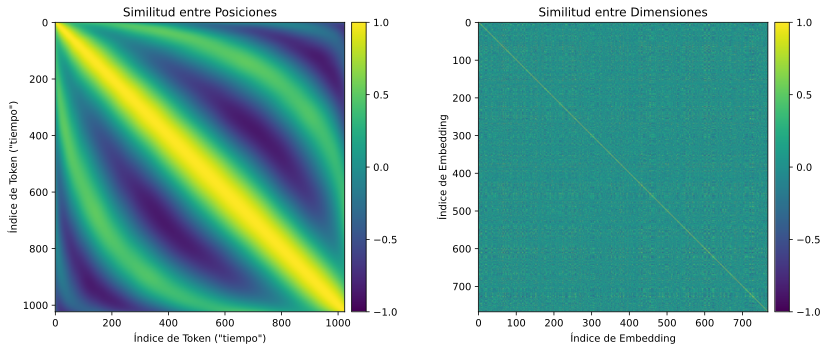

In [3]:
# Similitud coseno para "series temporales" (índice del token)
# Normalizamos por filas (axis=1) para comparar posiciones
Pnorm1 = positions / np.linalg.norm(positions, axis=1, keepdims=True)
cossim_tokens = Pnorm1 @ Pnorm1.T

# Similitud coseno a través de dimensiones de embedding
# Normalizamos por columnas (axis=0) para comparar dimensiones
Pnorm0 = positions / np.linalg.norm(positions, axis=0, keepdims=True)
cossim_embeds = Pnorm0.T @ Pnorm0

# Dibujar las imágenes
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: Similitud entre posiciones
h = axs[0].imshow(cossim_tokens, vmin=-1, vmax=1)
axs[0].set(xlabel='Índice de Token ("tiempo")', ylabel='Índice de Token ("tiempo")', title='Similitud entre Posiciones')
ch = fig.colorbar(h, ax=axs[0], pad=.02, fraction=.046)
ch.ax.tick_params(labelsize=10)
ch.ax.set_yticks(np.arange(-1, 1.1, .5))

# Gráfico 2: Similitud entre dimensiones
h = axs[1].imshow(cossim_embeds, vmin=-1, vmax=1)
axs[1].set(xlabel='Índice de Embedding', ylabel='Índice de Embedding', title='Similitud entre Dimensiones')
ch = fig.colorbar(h, ax=axs[1], pad=.02, fraction=.046)
ch.ax.tick_params(labelsize=10)
ch.ax.set_yticks(np.arange(-1, 1.1, .5))

plt.tight_layout()
plt.show()

## El Enfoque Matemático: Embeddings Sinusoidales

GPT-2 aprendió sus posiciones a la fuerza. Pero en el paper original de Transformers (*Attention Is All You Need*), propusieron una fórmula elegante basada en senos y cosenos de diferentes frecuencias.

$$PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d_{model}})$$

Esto crea un patrón de interferencia único para cada posición que el modelo puede extrapolar teóricamente a secuencias infinitas.

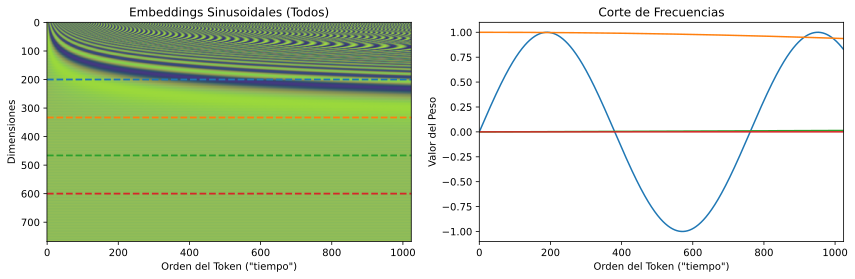

In [4]:
# Inicializar matriz con la misma forma que GPT-2 (1024, 768)
positionsFormula = np.zeros_like(gpt2.wpe.weight.data)
d = positionsFormula.shape[1] # 768 dimensiones

# Vector de posiciones ("tiempo") del 0 al 1023
th = np.arange(positionsFormula.shape[0])

# Crear los vectores usando la fórmula
for i in range(0, positionsFormula.shape[1], 2): # Saltos de 2 (seno y coseno)

  # Factor de escala del denominador (frecuencia)
  denom = 10000 ** (2*i / d) # Ojo: en algunas implementaciones es 2*i, en otras 2*i//2

  # Definir los embeddings
  positionsFormula[:, i]   = np.sin(th / denom)     # Pares: Seno
  positionsFormula[:, i+1] = np.cos(th / denom)     # Impares: Coseno

#### Visualizar
_, axs = plt.subplots(1, 2, figsize=(12, 4))

# Heatmap de toda la matriz
axs[0].imshow(positionsFormula.T, vmin=-1, vmax=1, aspect='auto')
axs[0].set(ylabel='Dimensiones', xlabel='Orden del Token ("tiempo")', title='Embeddings Sinusoidales (Todos)')

# Visualizar un corte específico (Zoom)
pos2show = np.linspace(200, 600, 4, dtype=int) # Elegimos 4 dimensiones para graficar
h = axs[1].plot(positionsFormula[:, pos2show])
axs[1].set(ylabel='Valor del Peso', xlabel='Orden del Token ("tiempo")', xlim=[0, len(th)], title='Corte de Frecuencias')

# Dibujar líneas guía en el heatmap
for i, p in enumerate(pos2show):
  axs[0].axhline(p, linestyle='--', color=h[i].get_color(), linewidth=1.8)

plt.tight_layout()
plt.show()

## Comparación Visual: Estructura vs. Ruido

Finalmente, graficamos las dimensiones individuales de la matriz sinusoidal usando la misma lógica que usamos con GPT-2 al principio.

Observa la diferencia:
* **GPT-2:** Líneas irregulares, espigas, "ruido" aparente.
* **Sinusoidal:** Ondas perfectas, suaves y predecibles.

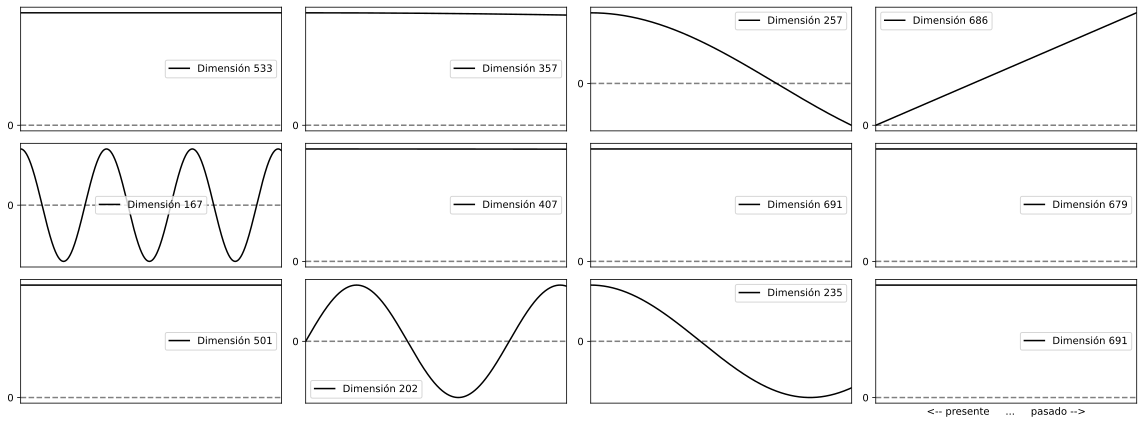

In [5]:
# Mismo plot que al inicio pero con los embeddings calculados por fórmula
_, axs = plt.subplots(3, 4, figsize=(16, 6))

# Elegir vectores aleatorios
for a in axs.flatten():

  # Una dimensión aleatoria
  randidx = np.random.randint(positions.shape[1])

  # Y graficarla
  a.plot(positionsFormula[:, randidx], 'k', label=f'Dimensión {randidx}')
  a.axhline(0, linestyle='--', color='gray', zorder=-3)

  a.set(xticks=[], yticks=[0], xlim=[0, positions.shape[0]])
  a.legend(fontsize=10)

# Etiqueta
a.set(xlabel='<-- presente     ...     pasado -->')
plt.tight_layout()
plt.show()

# Análisis de Resultados: Aprendido vs. Matemático

Al comparar `gpt2.wpe` (aprendido) con la fórmula matemática, las diferencias son notables y nos enseñan sobre la naturaleza del Deep Learning:

### 1. Estructura Local (Similitud Coseno)
En el gráfico de **"Token index over time"** de GPT-2, vimos una **banda diagonal brillante**.
* Esto significa que la posición $T$ es muy similar a $T+1$ y $T-1$.
* El modelo aprendió por sí solo que la "vecindad temporal" importa.

### 2. Caos vs. Orden
* **Matriz Sinusoidal:** Es geométricamente perfecta. Cada dimensión es una onda con una frecuencia diferente. Las dimensiones bajas (arriba en el gráfico) oscilan rápido; las altas oscilan lento.
* **Matriz GPT-2:** Parece "sucia". Sin embargo, funciona igual de bien (o mejor) para la tarea de generar texto en inglés.
* **Conclusión:** A las redes neuronales no les importa la estética humana. Pueden encontrar patrones utilizables dentro de lo que a nosotros nos parece ruido, siempre que ese ruido ayude a minimizar la función de pérdida.

### 3. Extrapolación
La gran ventaja teórica de los sinusoidales es que pueden manejar secuencias más largas que las vistas en el entrenamiento. GPT-2, al tener embeddings aprendidos posicionales fijos (hasta 1024), **no puede** procesar nada más allá del token 1024 sin trucos adicionales (como RoPE o ALiBi, técnicas modernas que combinan lo mejor de ambos mundos).